# Generating a dataset of instances of Gaussian Random Vectors $X$ from a given Covariance Matrix $K$ and Mean Vector $𝝁$

## Introduction

The aim of this task is to generate a dataset composed by instances of gaussian random vectors $X$, given a covariance matrix $K\in\mathbb{R}^{nxn}$ and a mean vector $\mu\in\mathbb{R}^n$.

We then estimate the covariance matrix of this generated dataset and compare it with the original covariance matrix $K$ from which the dataset is constructed. 

We use the method of ***Random Normal Vector Generation*** to generate the dataset composed by instances of *$X ∼ N(𝝁, K)$* , where $N$ is the gaussian distribution with a mean $\mu$ and covariance matrix $K$.

The procedure is described below :

- We start with a normal vector :  $Y ∼ Ν(0_n, I_n)$ $\space$ (it has $\mu$=0 and $K$=identity)  

- We need to find a linear transformation *A* such that : $ X = AY + 𝝁 $

- *A* can be found from the covariance matrix *K* : $ A = V ∙ √D  ∙V^T $ ; where V , D contain the eigenvectors and eigenvalues of *K* respectively. These are found by performing the spectral decomposition of *K*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
n = int(input("Enter the number of dimensions: "))
a = np.random.rand(n,n)

#covariance matrix K (symmetry asserted)
K = a.T @ a

#ZERO mean
u = np.full((n,), 0)

Enter the number of dimensions:  500


In [4]:
#spectral decomposition of K
l,v = np.linalg.eig(K)

d = np.zeros((n,n), float)
np.fill_diagonal(d,l)

In [5]:
#the required linear transformation A
A = v @ np.sqrt(d) @ v.T

In [6]:
#checking if the condition K = (A . A^T) holds True 
np.allclose(K, (A @ A.T))

True

Enter the number of samples:  2000
Which dimension to display? (0 to 499):  100


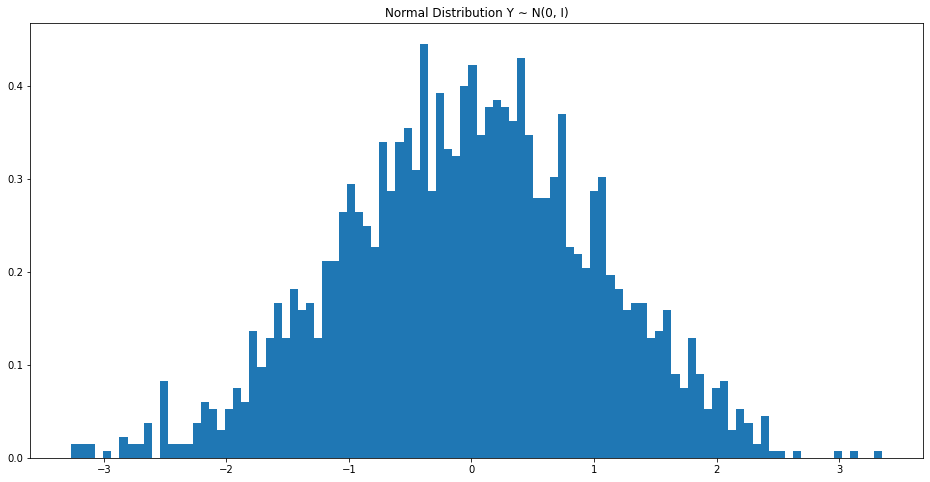

In [7]:
#Random Normal Vector

samples = int(input("Enter the number of samples: "))
col = int(input(f'Which dimension to display? (0 to {n-1}): ')) 
Y = np.random.multivariate_normal(np.zeros(n), np.identity(n), samples)
plt.figure(figsize=(16,8))
plt.title('Normal Distribution Y ∼ Ν(0, I)')
plt.hist(Y[:,col], 100, density=True)
None

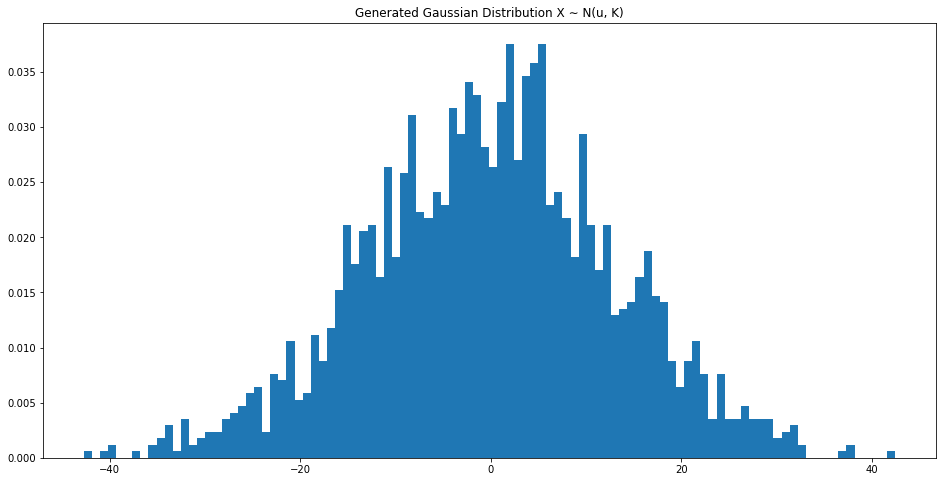

In [8]:
#Finally we generate the required Random Gaussian Vector X with mean 𝝁 and covariance matrix K 

X = (A @ Y.T).T + u 
plt.figure(figsize=(16,8))
plt.title('Generated Gaussian Distribution X ∼ Ν(u, K)')
plt.hist(X[:,col], 100, density=True)
None

# Assessment : Estimating the Covariance Matrix and Mean of the generated dataset

We estimate the covariance matrix and mean of the dataset that we just generated above and compare it with the actual covariance matrix *K* and mean $\mu$ from which the dataset was generated.

We then assess the error between the two and also the error between the actual and estimated eigenvalues of the covariance matrix. [[2]](https://www.netlib.org/lapack/lug/node75.html)

In [9]:
#estimated K
Kx = np.cov(X, rowvar=False)

#estimated u
ux = np.mean(X)

#spectral decomposition of Kx
lx,vx = np.linalg.eig(Kx)
dx = np.zeros((n,n), float)
np.fill_diagonal(dx,lx)

In [10]:
#Error in the estimation of covariance matrix
K_err = (np.linalg.norm(K - Kx, ord='fro') / np.linalg.norm(K, ord='fro')) * 100
print(f'The relative error in the estimation of covariance matrix K : {K_err:.1f}%')

#Error in the estimation of mean
u_err = np.mean((u - ux)**2)
print(f'\nMean Squared Error in estimating the mean u : {u_err: .2f}')

#Error between the actual and estimated eigenvalues of the covariance matrix
d_err = (np.linalg.norm(d - dx, ord='fro') / np.linalg.norm(d, ord='fro')) * 100
print(f'\nThe relative error between the actual and estimated eigenvalues of the covariance matrix K : {d_err:.1f}%')

The relative error in the estimation of covariance matrix K : 2.2%

Mean Squared Error in estimating the mean u :  0.02

The relative error between the actual and estimated eigenvalues of the covariance matrix K : 0.9%


# Power Method : Estimating the largest eigenvalue and eigenvector

The Power Method is an iterative algorithm that estimates the largest eigenvalue and the corresponding eigenvector of a diagonalizable matrix *K*. 

Two very important assumptions to be made for the Power method to work as expected [[1]](https://en.wikipedia.org/wiki/Power_iteration) : 

- The diagonalizable matrix *K* has an eigenvalue that is strictly greater in magnitude than its other eigenvalues.
- The starting vector $b_{k-1}$ has a non-zero component in the direction of an eigenvector associated with the dominant eigenvalue.

The largest eigenvector $ ν_1 $ and the largest eigenvalue $ λ_1 $ are estimated in the following way : 

$$ when \ k → ∞  $$


$$ b_k = \frac {K ∙ b_{k-1}}{‖K ∙ b_{k-1} ‖_2} → ν_1  $$ 

$$ a_k = \frac {b_k^T ∙ K ∙ b_k}{b_k^T ∙ b_k} → λ_1 $$

In [11]:
def power_method(K, iterations): 
    
    #starting vector (random)
    b_k = np.random.rand(n,1)[:,0]
    
    for _ in range(iterations):
        b_k1 = K @ b_k
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm
        
    a_k = (b_k.T @ K @ b_k) / (b_k.T @ b_k)
        
    return a_k, b_k

In [12]:
eigval, eigvec = power_method(K, 100)
print(f'True largest eigenvalue : {l[0]: .5f}')
print(f'\nEstimated largest eigenvalue : {eigval: .5f}')

True largest eigenvalue :  62585.57353

Estimated largest eigenvalue :  62585.57353


### Accuracy

In [13]:
true_eigval, true_eigvec = l[0], v[:,0]
err_eigval = (abs(eigval - true_eigval) / true_eigval) * 100
err_eigvec = np.mean((eigvec - true_eigvec)**2)

print(f'Relative Error in estimating largest eigenvalue : {err_eigval: .2f}%')
print(f'\nMean Squared Error in estimating largest eigenvector : {err_eigvec: .2f}')

Relative Error in estimating largest eigenvalue :  0.00%

Mean Squared Error in estimating largest eigenvector :  0.00


### Convergence

A slight modification is added to the Power Method in order to discuss the convergence of the algorithm. 
As highlighted before, the two assumptions have to be satisfied for the Power Method to successfully converge. 

Along with the diagonalizable matrix *K*, the true largest eigenvalue is passed along with a certain tolerance as deemed suitable by the user (0.0 in our case).

The result is the number of iterations the algorithm takes to converge within the specified tolerance level.

In [14]:
def power_method_convergence(K, true, eps):
    
    b_k = np.random.rand(n,1)[:,0]
    converge = False
    c = 1
    
    while not converge:
        b_k1 = K @ b_k
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm
        a_k = (b_k.T @ K @ b_k) / (b_k.T @ b_k)
        converge = abs(true - a_k) <= eps
        c += 1
        
        if c >= 10000:
            return print(f'Power Method failed to converge (exceeded 10,000 iterations)')
    
    return print(f'Converged after {c} iterations') 

In [15]:
power_method_convergence(K, l[0], 0.0)

Converged after 8 iterations


## Conclusion

Power Method is a very simple and effective algorithm provided the two assumptions hold up. It may fail to converge as can be seen above if one of the assumptions is not satisfied or the tolerance is too tight. 

> NOTE : If the Power Method keeps failing, it implies that the starting vector being chosen randomly each time has a zero component along the direction of the dominant eigenvector every single time. Either keep trying to run until it successfully converges or increase the tolerance from 0.0 to 0.01 (say).

## References

1. The official [Wikipedia](https://en.wikipedia.org/wiki/Power_iteration) page of Power Method
2. [Measuring errors](https://www.netlib.org/lapack/lug/node75.html)